# RAG Over PDFs with Nomic Embed Multimodal

![banner image](https://assets.nomicatlas.com/pdf-rag-nomic-embed-multimodal.png)

Nomic Embed Multimodal is an embedding model that processes both text and images. It can directly process the visual content in PDFs without requiring preprocessing steps like OCR or image captioning.

In this notebook, we demonstrate how to build multimodal RAG that can answer questions from PDFs containing both text and visual elements.

**Note: due to the use of Flash Attention in this notebook, compatible GPUs such as the Ampere series (A10, A100, etc) are required. It should cost you < $1 in Colab compute credits on an A100.**

## Setup

Make sure the required libraries are installed. Note that we use the Nomic fork of `colpali` (for compatibility with the new `nomic-embed-multimodal` model).

In [4]:
!sudo apt-get install --quiet -y poppler-utils

Reading package lists...
Building dependency tree...
Reading state information...
poppler-utils is already the newest version (22.02.0-2ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [5]:
!pip install -q git+https://github.com/nomic-ai/colpali.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [6]:
!pip install -q git+https://github.com/huggingface/transformers qwen-vl-utils[decord]==0.0.8 accelerate flash-attn matplotlib scikit-learn pdf2image requests

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
colpali-engine 0.3.9.dev63+gbf8dd3b requires transformers<4.50.0,>=4.49.0, but you have transformers 4.52.0.dev0 which is incompatible.


## Prepare PDF Data

We are going to use pdfs of arxiv papers.

In [7]:
import requests

PDFs = [
    {'title': "Attention Is All You Need", 'file': "https://arxiv.org/pdf/1706.03762"}
]

for pdf in PDFs:
    with open(f"/content/sample_data/{pdf['title']}.pdf", 'wb') as f:
        f.write(requests.get(pdf['file']).content)
    print("saved paper for", pdf['title'])

saved paper for Attention Is All You Need


In [8]:
PDFs = [
    {'title': "Attention Is All You Need", 'file': "https://arxiv.org/pdf/1706.03762"},
    {'title': "HR Law English", 'file': "https"}
]

In [9]:
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

def display_pdf_images(images_list):
    """Display all images in the provided list as subplots with 5 images per row."""
    num_images = len(images_list)
    num_rows = num_images // 5 + (1 if num_images % 5 > 0 else 0)
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4 * num_rows))
    if num_rows == 1:
        axes = [axes] if num_images == 1 else axes
    else:
        axes = axes.flatten()
    for i, img in enumerate(images_list):
        if i < len(axes):
            ax = axes[i]
            ax.imshow(img)
            ax.set_title(f"Page {i+1}")
            ax.axis('off')
    for j in range(num_images, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

for pdf in PDFs:
    pdf["images"] = convert_from_path(f"/content/sample_data/{pdf['title']}.pdf")

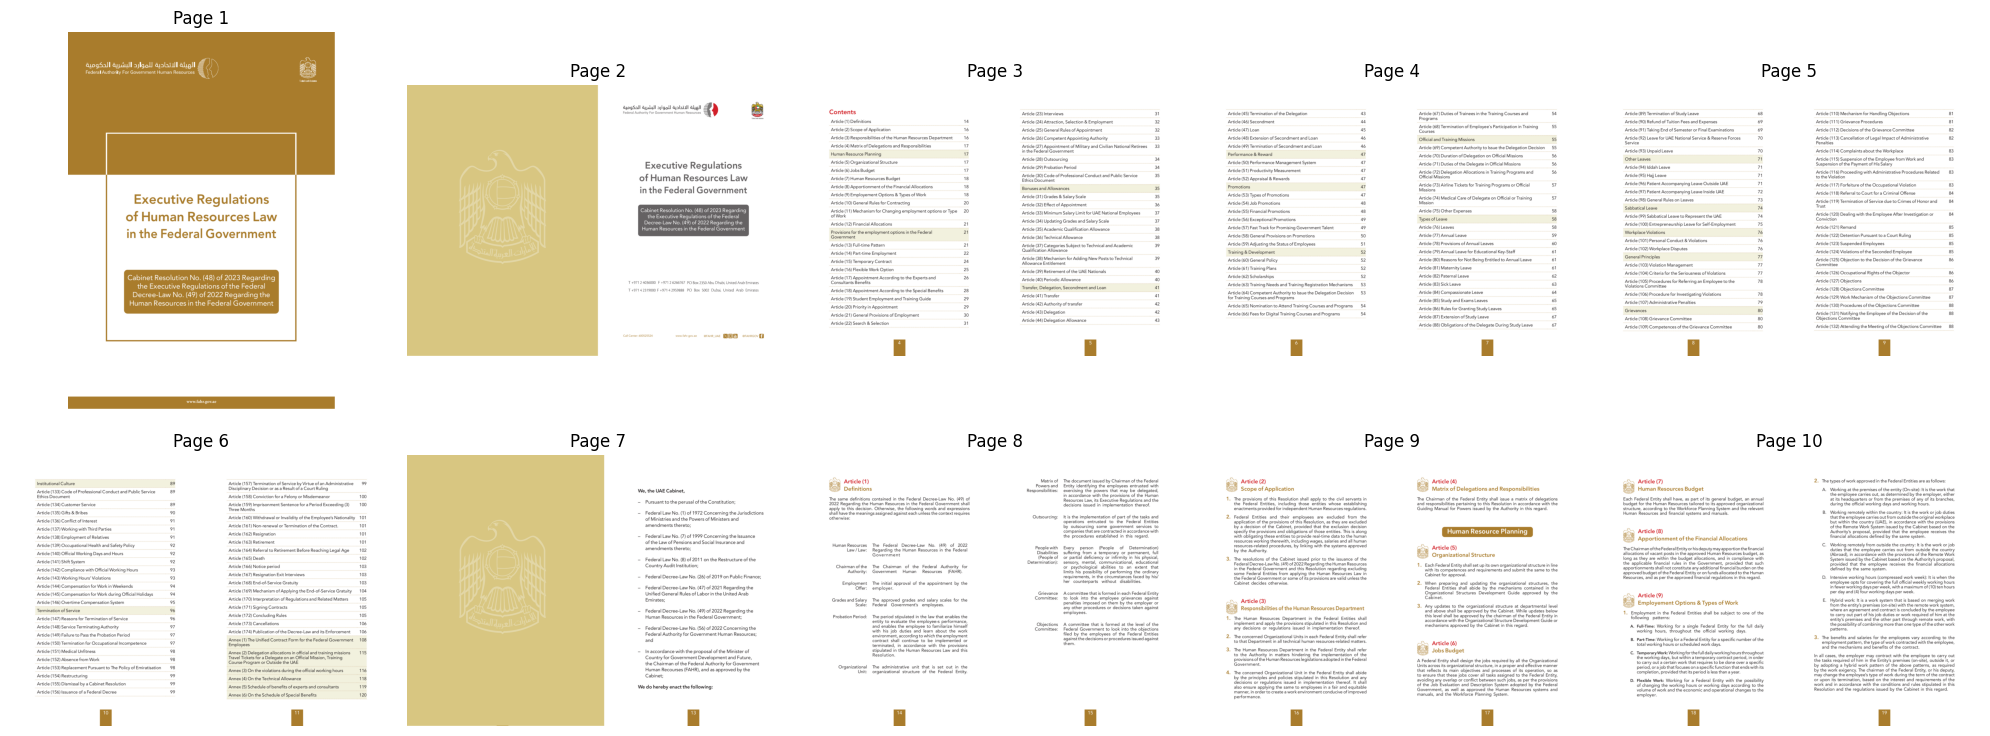

In [10]:
display_pdf_images(PDFs[1]["images"][:10])

# Embed PDFs

We use Nomic Embed Multimodal to create an embedding for each page of the PDFs. We will use these embeddings to measure which pages are most relevant to the user's query.

In [11]:
from colpali_engine.models.qwen2_5.biqwen2_5.modeling_biqwen2_5 import BiQwen2_5
from colpali_engine.models.qwen2_5.biqwen2_5.processing_biqwen2_5 import BiQwen2_5_Processor

In [12]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import torch
from torch.utils.data import Dataset

# Use smaller multimodal model
clip_model = SentenceTransformer("clip-ViT-B-32",device='cpu')
clip_model.eval()

# Create image dataset (same)
class PDFImageDataset(Dataset):
    def __init__(self, pdfs_list):
        self.images = []
        self.filenames = []
        for pdf in pdfs_list:
            for i, img in enumerate(pdf["images"]):
                self.images.append(img)
                self.filenames.append(f"{pdf['title']}_page_{i+1}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return {
            "image": self.images[idx],
            "image_filename": self.filenames[idx]
        }

# Generate embeddings
pdf_dataset = PDFImageDataset(PDFs)
image_counter = 0

for pdf in PDFs:
    print(f"Generating embeddings for {len(pdf['images'])} pages in {pdf['title']}")
    pdf['page_embeddings'] = []
    for img in pdf["images"]:
        with torch.no_grad():
            emb = clip_model.encode(img, convert_to_tensor=True, normalize_embeddings=True)
        pdf['page_embeddings'].append(emb)
        image_counter += 1

print(f"Generated embeddings for {image_counter} PDF pages")

# Collect all embeddings and metadata
embeddings = torch.stack([
    emb for pdf in PDFs for emb in pdf["page_embeddings"]
])

data = []
page_count = 0
for pdf in PDFs:
    for page_idx in range(len(pdf["images"])):
        data.append({
            "title": pdf["title"],
            "file": pdf["file"],
            "page_number": page_idx + 1,
            "image": pdf["images"][page_idx],
            "id": page_count
        })
        page_count += 1

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Generating embeddings for 15 pages in Attention Is All You Need
Generating embeddings for 63 pages in HR Law English
Generated embeddings for 78 PDF pages


## Setup Retrieval and VLM Querying

The `retrieve` function uses the embeddings generated by Nomic Embed Multimodal to retrieve the PDF pages closest to our query.

In [13]:
def retrieve(query: str, k: int = 3) -> list:
    """Retrieve semantically similar items using CLIP embeddings"""
    with torch.no_grad():
        query_embedding = clip_model.encode(query, convert_to_tensor=True, normalize_embeddings=True)

    cos_sim = util.cos_sim(query_embedding, embeddings)[0]
    idx_sorted_by_cosine_sim = torch.argsort(cos_sim, descending=True)
    sorted_data = [data[i] for i in idx_sorted_by_cosine_sim]
    return sorted_data[:k]


In [17]:
!pip install -U bitsandbytes
!pip install -U transformers accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.5.2
    Uninstalling accelerate-1.5.2:
      Successfully uninstalled accelerate-1.5.2


The `query_image` function uses a vision-language model (VLM) to ask a question of an image, which we will use to answer the user query.

In [1]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
from PIL.Image import Image
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,  # use float16 compute
    bnb_4bit_use_double_quant=True,        # slightly better quality
    bnb_4bit_quant_type="nf4"              # preferred for LLMs
)

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct",
    quantization_config=bnb_config,
    device_map="auto"
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct", use_flash_attention=False)

def query_vlm(query: str, images: list[Image]) -> str:
    """Queries Qwen VLM with text and images"""
    system_prompt = "You are an expert professional PDF analyst who gives rigorous in-depth answers."
    message_content = [
        {"type": "image", "image": image}
        for image in images
    ] + [{"type": "text", "text": query}]
    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_prompt}]
        },
        {
            "role": "user",
            "content": message_content
        }
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    ).to(model.device)
    generated_ids = model.generate(**inputs, max_new_tokens=1000)
    generated_ids_trimmed = generated_ids[0][len(inputs.input_ids[0]):]
    return processor.decode(generated_ids_trimmed, skip_special_tokens=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Plotting Helper Function

In [2]:
import textwrap
from matplotlib import gridspec
import numpy as np

def plot_rag_result(query: str, answer: str, images: list[Image]) -> None:
    """Plots user query, retrieved source doc as image(s), and VLM answer"""
    wrapped_query = '\n'.join(textwrap.wrap(query, width=70))
    num_images = len(images)
    fig = plt.figure(figsize=(14, 10))
    outer = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)
    if num_images == 1:
        ax1 = fig.add_subplot(outer[0])
        ax1.imshow(images[0])
        ax1.axis('off')
        ax1.set_title("Source Document\nretrieved by Nomic Embed Multimodal",
                      fontsize=12, fontweight='bold', loc='left', pad=0)
    else:
        left = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0])
        fig.text(0.1, 0.9, "Source Documents\nretrieved by Nomic Embed Multimodal",
                fontsize=12, fontweight='bold', va='top', ha='left')
        if num_images == 2:
            rows, cols = 1, 2
        else:
            cols = min(int(np.ceil(np.sqrt(num_images))), 3)
            rows = int(np.ceil(num_images / cols))
        inner = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=left[0],
                                                wspace=0.05, hspace=0.05)
        for i, image in enumerate(images):
            ax_sub = fig.add_subplot(inner[i])
            ax_sub.imshow(image)
            ax_sub.axis('off')
    ax2 = fig.add_subplot(outer[1])
    ax2.axis('off')
    ax2.set_title("Answer generated by Qwen 2.5 VL 7B Instruct", fontsize=12, fontweight='bold', loc='left')
    wrapped_answer = '\n'.join(['\n'.join(textwrap.wrap(line, width=80)) for line in answer.split('\n')])

    # shrink font as text gets longer
    fontsize = min(9, max(4, 9 - ((len(wrapped_answer) - 500) // 1000)))

    ax2.text(0.02, 0.97, wrapped_answer, transform=ax2.transAxes, fontsize=fontsize, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#2C3E50', linewidth=2, pad=1.0))
    fig.suptitle(f"Query: {wrapped_query}", fontsize=14, fontweight='bold', y=0.96)
    plt.show()

# Single Document Retrieval

In [14]:
single_doc_query = "How does the transformer architecture work?"
single_doc_rag_results = retrieve(single_doc_query, k=1)
single_doc_image = single_doc_rag_results[0]["image"]
single_doc_answer = query_vlm(single_doc_query, [single_doc_image])

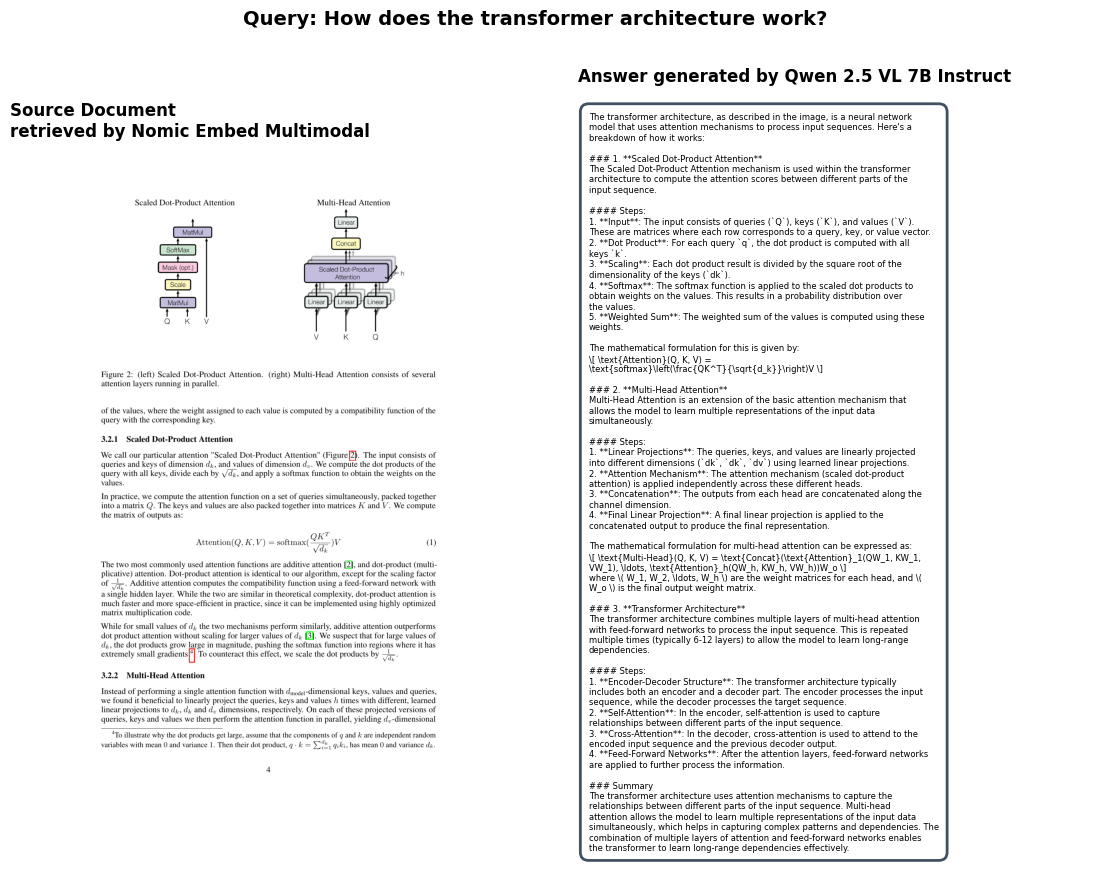

In [15]:
plot_rag_result(single_doc_query, single_doc_answer, [single_doc_image])

Now we'll display the page in more detail so you can see how the model's answers align with the retrieved source page.

In [ ]:
single_doc_image

In [ ]:
print(single_doc_answer)

# Multi Document Retrieval

In [ ]:
multi_doc_query = "What does the forward pass of a diffusion model look like?"
K = 2
multi_doc_rag_results = retrieve(multi_doc_query, k=K)
multi_doc_images = [x["image"] for x in multi_doc_rag_results]
multi_doc_answer = query_vlm(multi_doc_query, multi_doc_images)

In [ ]:
plot_rag_result(multi_doc_query, multi_doc_answer, multi_doc_images)

Now we'll display the pages in more detail so you can see how the model's answers align with the retrieved source pages.

In [ ]:
multi_doc_images[0]

In [ ]:
multi_doc_images[1]

In [ ]:
print(multi_doc_answer)